## 감정 어휘 사전

In [82]:
pip install afinn

Note: you may need to restart the kernel to use updated packages.


In [83]:
from sklearn.datasets import fetch_20newsgroups

newsdata = fetch_20newsgroups(subset='train')
newsdata.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [84]:
from afinn import Afinn

afinn = Afinn()
for i in range(10):
    print(afinn.score(newsdata.data[i]))

7.0
11.0
16.0
5.0
-23.0
-25.0
7.0
3.0
16.0
-20.0


In [85]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

postive = 0
neutral = 0 
negative = 0

for i in newsdata.data:
    score = afinn.score(i)
    if score > 0:
        postive += 1
    elif score == 0:
        neutral += 1
    else:
        negative += 1
        
plt.bar(np.arange(3), [postive, neutral, negative])
plt.xticks(np.arange(3), ['postive', 'neutral', 'negative'])
plt.show()

KeyboardInterrupt: 

## 기계학습을 이용한 감정 분석

In [ ]:
import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Read Data

In [86]:
train_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
test_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

KeyboardInterrupt: 

In [ ]:
train_data

## 중복 및 결측치 처리

In [ ]:
print(train_data['document'].nunique())
print(train_data['label'].nunique())

In [ ]:
train_data.drop_duplicates(subset = ['document'], inplace=True)

In [ ]:
print(train_data.isnull().sum())

train_data = train_data.dropna(how='any')

## Data preprocessing

### 데이터에서 한글과 공백을 제외하고 모두 제거

In [ ]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ 가-힣 ]", "")

train_data[:10]

In [ ]:
train_data['document'].replace('', np.nan, inplace=True)
print(len(train_data))
print(train_data.isnull().sum())

In [ ]:
train_data = train_data.dropna(how='any')
print(len(train_data))

In [ ]:
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ 가-힣 ]',"")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')

### 토큰화 및 불용어 제거
#### - 단어들을 분리하고 불용어를 제거함
#### - 불용어 사전 : '의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다'

In [ ]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [ ]:
mecab = Mecab()

X_train = []
for sentence in train_data['document']:
    X_train.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [ ]:
print(X_train[:1])

In [ ]:
X_test = []

for sentence in test_data['document']:
    X_test.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [ ]:
print(X_test[:2])

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

### 빈도수가 낮은 단어 제거

In [ ]:
threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    words_freq = words_freq + value
    
    if value < threshold: ## 3보다 낮으면 rare_cnt에 추가
        rare_cnt += 1
        rare_freq = rare_freq + value

print('전체 단어 수:', words_cnt)
print('빈도가 {} 이하인 rare 단어 수: {}'.format(threshold-1, rare_cnt))
print('희귀 단어 비율 :{}'.format((rare_cnt / words_cnt) * 100))
print('희귀 단어 등장 빈도 비율 : {}'.format((rare_freq / words_freq) * 100))

In [ ]:
vocab_size = words_cnt - rare_cnt + 2
print(vocab_size)

In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

### sentence 수가 적은 것을 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis = 0)
y_train = np.delete(y_train, drop_train, axis = 0)

### Padding
#### 리뷰의 전반적인 길이를 확인
#### 모델의 입력을 위해 동일한 길이로 맞춰줌

In [ ]:
print('리뷰 최대 길이:', max(len(l) for l in X_train))
print('리뷰 평균 길이:', sum(map(len, X_train))/len(X_train))

In [ ]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
max_len = 60

In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### Modeling
#### 감정 상태 분류 모델을 선언하고 학습
#### 모델은 일반적인 LSTM 모델을 사용

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
### Sequential이 모델인지?

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=15, batch_size=60, validation_split=0.2)

In [ ]:
hist_dict = history.history

loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss, 'b--', label = 'training loss')
plt.plot(val_loss, 'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label = 'training accuracy')
plt.plot(val_acc, 'r:', label = 'validation accuracy')
plt.legend()
plt.grid()

plt.show()

### 감정 예측

In [ ]:
def sentiment_predict(new_sentence):
    new_token = [word for word in mecab.morphs(new_sentence) if not word in stopwords]
    new_sequences = tokenizer.texts_to_sequences([new_token])
    new_pad = pad_sequences(new_sequences, maxlen = max_len)
    score = float(model.predict(new_pad))
    
    if score > 0.5:
        print("{} -> 긍정({:.2f}%)".format(new_sentence, score*100))
    else:
        print("{} -> 부정({:.2f}%)".format(new_sentence, score*100))

In [ ]:
sentiment_predict('정말 재미있고 흥미진진 했어요.')
sentiment_predict('어떻게 이렇게 지루하고 재미없죠?')
sentiment_predict("매우 연기력이 대박입니다.")
sentiment_predict('분위기가 어둡고 스토리가 복잡해요')

## 네이버 쇼핑 리뷰 데이터

### Read Data

In [87]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="shopping.txt")

('shopping.txt', <http.client.HTTPMessage at 0x7fd4c94c7670>)

In [88]:
total_data = pd.read_table('shopping.txt', names = ['ratings', 'reviews'])
print(len(total_data))

200000


In [89]:
total_data.head()

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


### Split data

In [90]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data.head()

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [91]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [92]:
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print(len(total_data))

199908


In [93]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state=111)
print(len(train_data))
print(len(test_data))

149931
49977


### 레이블의 분포 확인

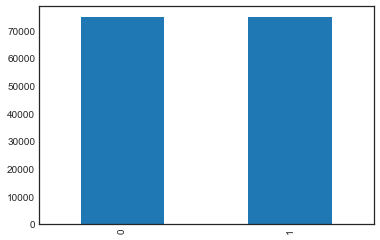

In [94]:
train_data['label'].value_counts().plot(kind = 'bar')
plt.show()

In [95]:
train_data.groupby('label').size().reset_index(name = 'count')

,label,count
0,0,74974
1,1,74957


### Data preprocessing

In [96]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149931 entries, 7565 to 129928
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   ratings  149931 non-null  int64 
 1   reviews  149931 non-null  object
 2   label    149931 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [97]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
train_data['reviews'].replace("", np.nan, inplace=True)
train = train_data.dropna(how='any')
print(len(train_data))

/var/folders/xb/jj9xzp2d6v37h6nvn74k10p00000gn/T/ipykernel_5628/2670499658.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
/var/folders/xb/jj9xzp2d6v37h6nvn74k10p00000gn/T/ipykernel_5628/2670499658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
/Users/jody/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

149931


In [98]:
test_data.drop_duplicates(subset=['reviews'], inplace =True)
test_data['reviews'] = test_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', "")
test_data['reviews'].replace("", np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print(len(test_data))

49977


/Users/jody/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/var/folders/xb/jj9xzp2d6v37h6nvn74k10p00000gn/T/ipykernel_5628/1318016301.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', "")
/var/folders/xb/jj9xzp2d6v37h6nvn74k10p00000gn/T/ipykernel_5628/1318016301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['reviews'] = test

In [99]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [100]:
mecab = Mecab()

train_data['reviews'] = train_data['reviews'].apply(mecab.morphs)
train_data['reviews'] = train_data['reviews'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['reviews'] = test_data['reviews'].apply(mecab.morphs)
test_data['reviews'] = test_data['reviews'].apply(lambda x: [item for item in x if item not in stopwords])

/var/folders/xb/jj9xzp2d6v37h6nvn74k10p00000gn/T/ipykernel_5628/3345175466.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['reviews'] = train_data['reviews'].apply(mecab.morphs)
/var/folders/xb/jj9xzp2d6v37h6nvn74k10p00000gn/T/ipykernel_5628/3345175466.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['reviews'] = train_data['reviews'].apply(lambda x: [item for item in x if item not in stopwords])


In [102]:
X_train = train_data['reviews'].values
y_train = train_data['label'].values
X_test = test_data['reviews'].values
y_test = test_data['label'].values

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(149931,)
(49977,)
(149931,)
(49977,)


### 빈도수가 낮은 단어 제거

In [103]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [106]:
threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    words_freq = words_freq + value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq = rare_freq + value

print("전체 단어 수:", words_cnt)
print('빈도가 {} 이하인 희귀 단어 수:{}'.format(threshold-1, rare_cnt))
print('희귀 단어 비율 : {}'.format((rare_cnt / words_cnt) * 100))
print('희귀 단어 등장 빈도 비율 : {}'.format((rare_freq / words_freq) * 100))

전체 단어 수: 40064
빈도가 2 이하인 희귀 단어 수:23110
희귀 단어 비율 : 57.68270766773163
희귀 단어 등장 빈도 비율 : 1.1289716278874666


In [107]:
vocab_size = words_cnt - rare_cnt + 2
print(vocab_size)

16956


In [108]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [109]:
print(X_train[:2])

[[5410, 5, 17, 264, 18, 1429, 106], [90, 112, 269, 102, 11, 31, 21, 19, 4, 617, 281, 214, 565, 1571, 3193, 1578, 350, 2, 218, 270, 17, 566, 743, 1210, 84, 42, 153, 144, 5560, 1615, 102, 547, 53, 61, 5059, 4, 81]]


### Padding

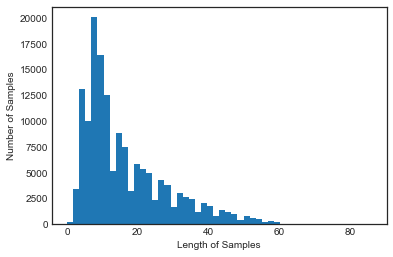

In [110]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [111]:
max_len = 60

In [112]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### Modeling

In [113]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [114]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation = 'sigmoid'))

In [115]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose= 1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose=1, save_best_only = True)

In [116]:
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks = [es,mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.2783 - acc: 0.8946
Epoch 00001: val_acc improved from -inf to 0.91153, saving model to best_model.h5
2000/2000 [==============================] - 71s 34ms/step - loss: 0.2783 - acc: 0.8946 - val_loss: 0.2363 - val_acc: 0.9115
Epoch 2/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.2163 - acc: 0.9201
Epoch 00002: val_acc improved from 0.91153 to 0.91873, saving model to best_model.h5
2000/2000 [==============================] - 73s 36ms/step - loss: 0.2163 - acc: 0.9201 - val_loss: 0.2240 - val_acc: 0.9187
Epoch 3/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2000 - acc: 0.9275
Epoch 00003: val_acc improved from 0.91873 to 0.92053, saving model to best_model.h5
2000/2000 [==============================] - 74s 37ms/step - loss: 0.2000 - acc: 0.9275 - val_loss: 0.2180 - val_acc: 0.9205
Epoch 4/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1894 - acc: 0.9320
E

In [117]:
loaded_model = load_model('best_model.h5')
loaded_model.evaluate(X_test, y_test)

1562/1562 [==============================] - 14s 9ms/step - loss: 0.2108 - acc: 0.9244


[0.2107500433921814, 0.9244452714920044]

### 감정 예측

In [128]:
def sentiment_predict(new_sentence):
    new_token = [word for word in mecab.morphs(new_sentence) if word not in stopwords]
    new_sequences = tokenizer.texts_to_sequences([new_token])
    new_pad = pad_sequences(new_sequences, maxlen = max_len)
    score = float(loaded_model.predict(new_pad))
    
    if score > 0.5:
        print("{} -> 긍정({:.2f}%)".format(new_sentence, score*100))
    else:
        print("{} -> 부정({:.2f}%)".foramt(new_sentence, (1-score) * 100))


In [129]:
sentiment_predict('처음 써봤는데 대박 좋아요.')
sentiment_predict('원래 배송이 이렇게 늦나요?')
sentiment_predict('좋은거 인정! 추가 구매 의향 있습니다.')
sentiment_predict('이건 정말 리뷰 쓰는게 아깝네요.')

처음 써봤는데 대박 좋아요. -> 긍정(96.68%)


AttributeError: 'str' object has no attribute 'foramt'